# 走出第一步 

有了大小和方向，接下来我们就可以开始走出我们的第一步了。来看权重的迭代公式:

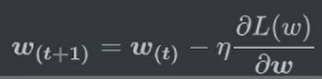

现在我们的偏导数部分已经计算出来了，就是我们使用backward求解出的结果。而n学习率，或者步长，是我们在迭代开始之前就人为设置好的，一般是0.01~0.5之间的某个小数。因此现在我们已经可以无障碍地使用代码实现权重的迭代了:

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
# 确定数据
# 此时数据没有requires_grad = True
torch.manual_seed(420)
X = torch.rand((500,20),dtype = torch.float32) * 100
y = torch.randint(low = 0,high = 3,size = (500,),dtype = torch.float32)
# 确定神经网络的架构
# LogSoftmax + NLLLoss / CrossEntropyLoss
# BCE,BCEWithLogitLoss
class Model(nn.Module):
    def __init__(self,in_features = 40,out_features = 2):
        super().__init__()
        self.linear1 = nn.Linear(in_features,13,bias=False)
        self.linear2 = nn.Linear(13,8,bias=False)
        self.output = nn.Linear(8,out_features,bias = True)
    
    def forward(self,x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat
input_ = X.shape[1]
output_ = len(y.unique())
# 实例化神经网络的类
torch.manual_seed(420)
net = Model(in_features=input_,out_features=output_)
zhat = net.forward(X)
# 定义损失函数
criterion = nn.CrossEntropyLoss()
loss = criterion(zhat,y.long())
# 执行反向传播
loss.backward(retain_graph=True) # 保存动态计算图

In [2]:
net # 正向传播，反向传播

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=False)
  (linear2): Linear(in_features=13, out_features=8, bias=False)
  (output): Linear(in_features=8, out_features=3, bias=True)
)

In [8]:
# w(t+1) = w(t) - 步长 * grad

# learning_rate
lr = 10

# 现有的权重，w(t)
w = net.linear1.weight.data

# 梯度
dw = net.linear1.weight.grad

In [175]:
# w(t+1) = w(t) - 步长 * grad
w -= lr * dw
w

tensor([[ 6.3944e-01, -1.0309e-02,  8.2215e-01, -1.1342e-01,  1.4874e-01,
         -5.7040e-02,  7.2545e-01,  5.1322e-01,  4.4965e-02, -1.0219e-01,
          1.9709e-03,  2.0884e-01,  3.8719e-02,  7.0267e-01,  8.6765e-02,
         -3.8327e-02,  1.4691e-01, -2.1104e-01,  5.1995e-02,  1.9894e-02],
        [-1.6715e+01,  1.8284e+00, -1.9905e+01, -1.8585e+00, -8.5334e+00,
         -5.9994e+00, -1.0168e+01, -6.6790e+00, -2.4985e+01, -1.5073e+01,
         -9.9327e+00, -1.2451e+01, -2.2920e+01, -2.1741e+00, -1.5084e+01,
         -1.6333e+01, -2.9277e+01, -1.7087e+01, -2.9818e+00, -1.2075e+00],
        [ 1.7184e+01, -1.3200e+01, -4.8903e+00, -1.2417e+01, -7.1048e+00,
         -1.4970e+00, -1.5147e+01, -1.0708e+01,  9.7130e+00, -1.7395e+00,
          4.5466e+00, -1.0753e+01,  4.7151e+00,  7.2384e+00,  8.4665e+00,
         -1.3788e+01,  1.6955e+01,  1.4296e+01, -3.7573e+00,  2.0389e+00],
        [ 2.2532e+01,  1.7444e+01,  1.3855e+01,  2.6138e+01,  2.0356e+01,
          2.7313e+01,  1.6127e+01, 

普通梯度下降就是在重复正向传播、计算梯度、更新权重的过程，但这个过程往往非常漫长。如大家所见，步长设置为0.001时，我们看不到w任何的变化，只有当步长设置得非常巨大，我们才能够看到一些改变，但在之前的课程中我们说过，巨大的步长可能会让我们跳过真正的最小值，所以我们无法将步长设置得很大，无论如何，梯度下降都是一个缓慢的过程。在这个基础上，我们提出了加速迭代的数个方法，其中一个很关键的方法，就是使用动量Momentum。

#  从第一步到第二步：动量法Momentum

不难发现，真正高效的方法是: 在历史方向与现有方向相同的情况下，迈出大步子，在历史方向与现有方向相反的情况下，迈出小步子。那要怎么才能让起始点了解过去的方向呢?我们让上一步的梯度向量 (的反方向) 与现在这一点的梯度向量 (的反方向) 以加权的方式求和，求解出受到上一步大小和方向影响的真实下降方向，再让坐标点向真实下降方向移动。在坐标轴上，可以表示为:

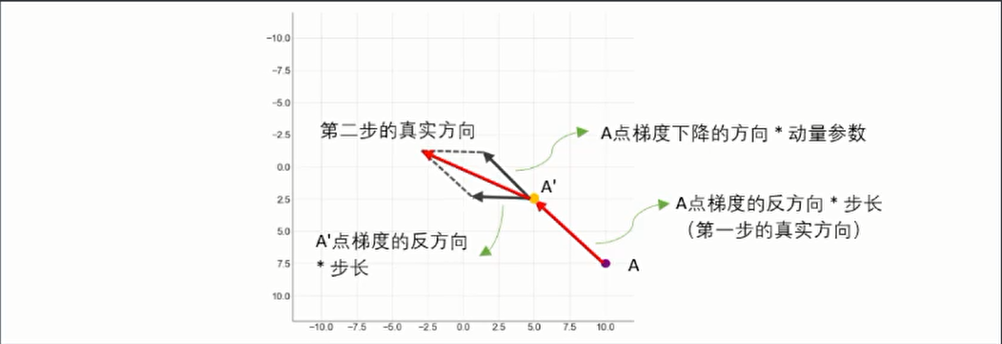

其中，对上一步的梯度向量加上的权重被称为动量参数(也叫做衰减力度，通常使用~进行表示)，对这一点的梯度向量加上的权重就是步长(依然表示为n) ，真实移动的向量为v，被称为”动量“(Momentum) 。将上述过程使用公式表示，则有:

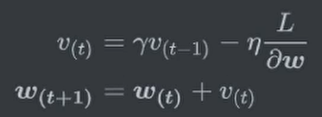

在第一步中，没有历史梯度方向，因此第一步的真实方向就是起始点梯度的反方向vo =0。其中v(t-1)代表了之前所有步骤所累积的动量和(其实也就代表着上一步的真真实方向)。在这种情况下，梯度下降的方向有了“惯性”，受到历史累计动量的影响，当新坐标点的梯度反方向与历史累计动量的方向一致时，历史累计动量会加大实际方向的步子，相反，当新坐标点的梯度反方向与历史累计动量的方向不一致时，历史累计动量会减小实际方向的步子

我们可以很容易地在PyTorch中实现动量法

In [178]:
# momentum
# v(t) = gamma * v(t-1) - lr * dw
# w(t+1) = w(t) + v(t)

lr = 0.1
gamma = 0.9
dw = net.linear1.weight.grad
w = net.linear1.weight.data

In [179]:
# t = 1, 走第一步，进行首次迭代的时候，需要一个V0
v = torch.zeros(dw.shape[0],dw.shape[1])

In [541]:
# v(t) = gamma * v(t-1) - lr * dw
v = gamma * v - lr * dw
# w(t+1) = w(t) + v(t)
w += v
w

tensor([[ 7.4637e-01,  1.6120e-02,  9.5172e-01, -9.9771e-02,  1.9488e-01,
         -3.6400e-02,  8.4304e-01,  6.0451e-01,  7.8243e-02, -8.7150e-02,
          2.9922e-02,  2.6242e-01,  7.1223e-02,  8.1744e-01,  1.2522e-01,
         -1.5370e-02,  1.9282e-01, -2.0948e-01,  8.6144e-02,  5.0065e-02],
        [-2.0280e+01,  2.1785e+00, -2.4143e+01, -2.2259e+00, -1.0368e+01,
         -7.2549e+00, -1.2308e+01, -8.0902e+00, -3.0273e+01, -1.8283e+01,
         -1.2084e+01, -1.5105e+01, -2.7823e+01, -2.5952e+00, -1.8254e+01,
         -1.9800e+01, -3.5503e+01, -2.0750e+01, -3.5740e+00, -1.4841e+00],
        [ 2.0879e+01, -1.6015e+01, -5.9617e+00, -1.5064e+01, -8.6308e+00,
         -1.8455e+00, -1.8415e+01, -1.2955e+01,  1.1763e+01, -2.1486e+00,
          5.4864e+00, -1.2997e+01,  5.7507e+00,  8.8243e+00,  1.0246e+01,
         -1.6766e+01,  2.0606e+01,  1.7298e+01, -4.5118e+00,  2.4783e+00],
        [ 2.7285e+01,  2.1162e+01,  1.6796e+01,  3.1662e+01,  2.4725e+01,
          3.3109e+01,  1.9580e+01, 

# torch.optim实现带动量的梯度下降

在PyTorch库的架构中，拥有专门实现优化算法的模块torch.optim。我们在之前的课程中所说的迭代流程，都可以通过torch.optim模块来简单地实现。

接下来，我们就基于之前定义的类Model来实现梯度下降的一轮迭代

In [773]:
# 导入库
# 确定数据、超参数的确定（lr,gamma）
# 定义神经网络的架构类Model,定义类Model需要输入的参数
# 实例化神经网络的类 - 让神经网络准备好进行正向传播
# 定义损失函数
# 定义优化算法

In [774]:
# 导入库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [775]:
# 确定数据、超参数的确定（lr,gamma）

# 确定数据
torch.manual_seed(420)
X = torch.rand((500,20),dtype = torch.float32) * 100
y = torch.randint(low = 0,high = 3,size = (500,),dtype = torch.float32)
# 确定超参数
lr = 0.1
gamma = 0.9

In [776]:
# 定义神经网络的架构类Model,定义类Model需要输入的参数

# 定义神经网络的架构类Model
# LogSoftmax + NLLLoss / CrossEntropyLoss
# BCE,BCEWithLogitLoss

class Model(nn.Module):
    def __init__(self,in_features = 40,out_features = 2):
        super().__init__()
        self.linear1 = nn.Linear(in_features,13,bias=False)
        self.linear2 = nn.Linear(13,8,bias=False)
        self.output = nn.Linear(8,out_features,bias = True)
    
    def forward(self,x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat
    
# 定义类Model需要输入的参数
input_ = X.shape[1] # 特征的数目
output_ = len(y.unique()) # 分类的数目

In [777]:
# 实例化神经网络的类 - 让神经网络准备好进行正向传播
torch.manual_seed(420)
net = Model(in_features=input_,out_features=output_)

In [778]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [779]:
# 定义优化算法
# 参数：需要进行迭代的权重，学习率， 动量参数
opt = optim.SGD(net.parameters(),lr = lr,  momentum = gamma)

    #一次性导出现有神经网络架构下全部的权重和截距
    net.parameters()
    for x in net.parametersrs():
        print(x)

In [780]:
# 向前传播
# 计算本轮向前传播的损失函数值
# 反向传播 - 得到梯度
# 更新权重和动量
# 清空梯度 - 清除原来计算出来的，基于上一个点的坐标计算的梯度

In [781]:
# 向前传播
zhat = net.forward(X) #最后一个线性层的输出结果

# 计算本轮向前传播的损失函数值
loss = criterion(zhat,y.reshape(500).long())

# 反向传播 - 得到梯度
loss.backward()

# 更新权重和动量
opt.step()# 走一步，更新权重w, 更新动量v

# 清空梯度 - 清除原来计算出来的，基于上一个点的坐标计算的梯度
opt.zero_grad()

print(loss)
print(net.linear1.weight.data[0][:10])

tensor(1.1559, grad_fn=<NllLossBackward0>)
tensor([ 0.1366, -0.1346,  0.2128, -0.1776, -0.0682, -0.1541,  0.1725,  0.0839,
        -0.1115, -0.1729])
